In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [148]:
companies = pd.read_csv("companies.txt",delimiter="\t",encoding = "ISO-8859-1")
companies.permalink = companies.permalink.str.lower()
companies.permalink = companies.permalink.map(lambda x:x.encode('utf-8').decode('ascii', 'ignore'))


In [149]:
companies.permalink = companies.permalink.str.lower()
rounds2 = pd.read_csv("rounds2.csv",encoding = "ISO-8859-1")
rounds2.company_permalink = rounds2.company_permalink.str.lower()
rounds2.company_permalink = rounds2.company_permalink.map(lambda x:x.encode('utf-8').decode('ascii', 'ignore'))

rounds2.shape[0]

114949

In [150]:
rounds2.company_permalink.nunique()

66368

In [151]:
companies.permalink.nunique()

66368

In [152]:
companies[~companies.permalink.isin(rounds2.company_permalink)].permalink

Series([], Name: permalink, dtype: object)

In [153]:
rounds2[~rounds2.company_permalink.isin(companies.permalink)].company_permalink

Series([], Name: company_permalink, dtype: object)

In [154]:
masterFrame = pd.merge(companies,rounds2,how='inner',left_on='permalink',right_on='company_permalink')
masterFrame.shape[0]

114949

In [155]:
pd.options.display.float_format='{:20,.2f}'.format
rounds2['funding_round_type']= rounds2['funding_round_type'].str.lower()
rounds2_by_funding_round=rounds2.groupby('funding_round_type')
rounds2_by_funding_round_mean = pd.DataFrame(rounds2_by_funding_round['raised_amount_usd'].mean())

In [156]:
#Find investment for venture funding type
venture_investment_amount = rounds2_by_funding_round_mean.loc['venture',]
venture_investment_amount

raised_amount_usd          11,748,949.13
Name: venture, dtype: float64

In [157]:
#Find investment for angel funding type
angel_investment_amount = rounds2_by_funding_round_mean.loc['angel',]
angel_investment_amount

raised_amount_usd             958,694.47
Name: angel, dtype: float64

In [158]:
#Find investment for seed funding type
seed_investment_amount = rounds2_by_funding_round_mean.loc['seed',]
seed_investment_amount

raised_amount_usd             719,818.00
Name: seed, dtype: float64

In [159]:
#Find investment for private equity funding type
private_equity_investment_amount = rounds2_by_funding_round_mean.loc['private_equity',]
private_equity_investment_amount

raised_amount_usd          73,308,593.03
Name: private_equity, dtype: float64

In [160]:
#find fundting type whose amount is satisfying the criteria that Spark Funds wants to invest between 5 to 15 million USD per investment round, 
preferred_investment_type = rounds2_by_funding_round_mean[(rounds2_by_funding_round_mean['raised_amount_usd']>=5000000) & (rounds2_by_funding_round_mean['raised_amount_usd']<=15000000)].iloc[0]
preferred_investment_type.name

'venture'

In [161]:
#For further analysis, filter the data so it only contains the chosen investment type
masterFrame = masterFrame[masterFrame.funding_round_type==preferred_investment_type.name]
rounds2_with_preferrable_funding_type=rounds2[rounds2.funding_round_type==preferred_investment_type.name]


In [162]:
masterFrame_by_country = masterFrame.groupby('country_code')


In [163]:
#Create a data frame with the top nine countries based on the total investment amount each country has received
top9 = pd.DataFrame(masterFrame_by_country.raised_amount_usd.sum()).sort_values(['raised_amount_usd'],ascending=[False]).iloc[:9,]   
top9

,raised_amount_usd
country_code,
USA,"422,510,842,796.00"
CHN,"39,835,418,773.00"
GBR,"20,245,627,416.00"
IND,"14,391,858,718.00"
CAN,"9,583,332,317.00"
FRA,"7,259,536,732.00"
ISR,"6,907,514,579.00"
DEU,"6,346,959,822.00"
JPN,"3,363,676,611.00"


In [164]:
#read sector mapping details as a dataframe
#drop na values
sector_mapping = pd.read_csv("mapping.csv")
sector_mapping =  sector_mapping.dropna(subset=['category_list'])
sector_mapping.category_list =  sector_mapping.category_list.map(lambda x:x.replace("0","n"))
sector_mapping.category_list = sector_mapping.category_list.str.lower()

In [165]:
#segregate category list per company
#extract the primary sector of each category list from the category_list column
masterFrame['primary_sector'] = masterFrame['category_list'].astype("str").apply(lambda x:x.split("|")[0])
masterFrame.primary_sector = masterFrame.primary_sector.str.lower()

In [166]:
#function to check whether the primary sector value is 1
def get_main_sector(row):
    for counter in range(1,10):
        if row.iloc[counter]==1:
            #Value of 1 means its the primary sector we are looking for
            break
    #return main_sector value from the row_index
    return row.index[counter]

In [167]:
#add a new column named 'main_sector' in the sector_mapping data frame  
sector_mapping['main_sector'] = sector_mapping.apply(get_main_sector, axis=1)


In [168]:
#merge master data frame with sectors data along with master_sector details
masterFrame = pd.merge(sector_mapping,masterFrame,how = 'inner', left_on='category_list',right_on='primary_sector')


In [169]:
#create three separate data frames for each of the three countries containing the observations 
#of funding type FT falling within the 5-15 million USD range

masterFrame_usa = masterFrame[masterFrame.country_code=='USA'].dropna(subset=['raised_amount_usd'])
masterFrame_gbr = masterFrame[masterFrame.country_code=='GBR'].dropna(subset=['raised_amount_usd'])
masterFrame_ind = masterFrame[masterFrame.country_code=='IND'].dropna(subset=['raised_amount_usd'])


In [170]:
#find total number of Investments (count) per country
total_number_of_investments_usa = masterFrame_usa.shape[0]
total_number_of_investments_gbr = masterFrame_gbr.shape[0]
total_number_of_investments_ind = masterFrame_ind.shape[0]


print("USA = "+str(total_number_of_investments_usa) +  " GBR = "+ str(total_number_of_investments_gbr) +" IND = "  + str(total_number_of_investments_ind))

USA = 33522 GBR = 1916 IND = 745


In [171]:
total_amount_investments_usa = masterFrame_usa.raised_amount_usd.sum()
total_amount_investments_gbr = masterFrame_gbr.raised_amount_usd.sum()
total_amount_investuments_ind = masterFrame_ind.raised_amount_usd.sum()
print("USA = "+str(total_amount_investments_usa) +  " GBR = "+ str(total_amount_investments_gbr) +" IND = "  + str(total_amount_investments_ind))


USA = 392212193021.0 GBR = 18924390319.0 IND = 13537981235.0


In [172]:
#compute top 3 sectors by investment count per country
top3_sectors_usa = masterFrame_usa.groupby("main_sector").agg({'primary_sector':'count','raised_amount_usd':'sum'}).sort_values('primary_sector',ascending=False).iloc[:3,]
top3_sectors_gbr = masterFrame_gbr.groupby("main_sector").agg({'primary_sector':'count','raised_amount_usd':'sum'}).sort_values('primary_sector',ascending=False).iloc[:3,]
top3_sectors_ind = masterFrame_ind.groupby("main_sector").agg({'primary_sector':'count','raised_amount_usd':'sum'}).sort_values('primary_sector',ascending=False).iloc[:3,]
top3_sectors_usa['main_sector_column'] = top3_sectors_usa.index
top3_sectors_gbr['main_sector_column'] = top3_sectors_gbr.index
top3_sectors_ind['main_sector_column'] = top3_sectors_ind.index

In [173]:
#figure out company that received highest investment by top sector count-wise
top_company_by_investment_usa = pd.DataFrame(masterFrame_usa[masterFrame_usa.main_sector==top3_sectors_usa.iloc[0].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name
top_company_by_investment_gbr = pd.DataFrame(masterFrame_gbr[masterFrame_gbr.main_sector==top3_sectors_gbr.iloc[0].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name
top_company_by_investment_ind = pd.DataFrame(masterFrame_ind[masterFrame_ind.main_sector==top3_sectors_ind.iloc[0].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name


In [174]:
#figure out company that received highest investment by second top sector count-wise
second_top_company_by_investment_usa = pd.DataFrame(masterFrame_usa[masterFrame_usa.main_sector==top3_sectors_usa.iloc[1].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name
second_top_company_by_investment_gbr = pd.DataFrame(masterFrame_gbr[masterFrame_gbr.main_sector==top3_sectors_gbr.iloc[1].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name
second_top_company_by_investment_ind = pd.DataFrame(masterFrame_ind[masterFrame_ind.main_sector==top3_sectors_ind.iloc[1].name].groupby('company_permalink').raised_amount_usd.sum()).sort_values('raised_amount_usd',ascending=False).iloc[0].name


In [175]:
#Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. The three data frames should contain:
#All the columns of the master_frame along with the primary sector and the main sector
#The total number (or count) of investments for each main sector in a separate column
#The total amount invested in each main sector in a separate column

D1 = pd.merge(masterFrame_usa,top3_sectors_usa,how="inner",left_on="main_sector",right_on="main_sector_column")
D2 = pd.merge(masterFrame_gbr,top3_sectors_gbr,how="inner",left_on="main_sector",right_on="main_sector_column")
D3 = pd.merge(masterFrame_ind,top3_sectors_ind,how="inner",left_on="main_sector",right_on="main_sector_column")

In [176]:
masterFrame_all_data = pd.merge(rounds2,companies,how='inner',left_on='company_permalink',right_on='permalink')
masterFrame_all_data = masterFrame_all_data.dropna(subset=["raised_amount_usd"])

In [177]:
masterFrame_inv_sum_against_count_by_funding_type = masterFrame_all_data[masterFrame_all_data.funding_round_type.str.lower().isin(["seed","venture","private_equity"])].groupby("funding_round_type").agg({'raised_amount_usd':['count','sum']})

In [178]:
masterFrame_inv_sum_against_count_by_funding_type.columns = masterFrame_inv_sum_against_count_by_funding_type.columns.map('_'.join)
masterFrame_inv_sum_against_count_by_funding_type
masterFrame_inv_sum_against_count_by_funding_type['funding_round_type'] = masterFrame_inv_sum_against_count_by_funding_type.index
masterFrame_inv_sum_against_count_by_funding_type

,raised_amount_usd_count,raised_amount_usd_sum,funding_round_type
funding_round_type,,,
private_equity,1936,"141,925,436,105.00",private_equity
seed,23603,"16,989,864,181.00",seed
venture,50228,"590,126,216,876.00",venture


In [179]:
masterFrame_inv_sum_against_count_by_funding_type['fraction'] = masterFrame_inv_sum_against_count_by_funding_type.raised_amount_usd_sum/masterFrame_inv_sum_against_count_by_funding_type.raised_amount_usd_count

In [180]:
masterFrame_inv_sum_against_count_by_funding_type['funding_round_type'] = masterFrame_inv_sum_against_count_by_funding_type.index


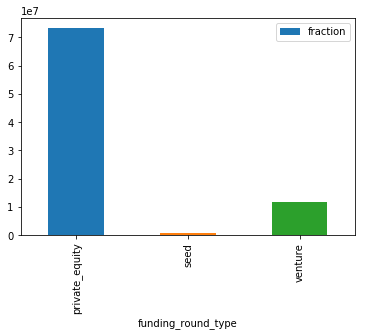

In [181]:
#plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type
masterFrame_inv_sum_against_count_by_funding_type.plot.bar(x="funding_round_type",y="fraction")


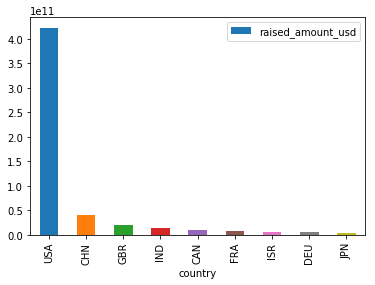

In [182]:
#plot showing the top 9 countries against the total amount of investments of funding type FT
top9['country'] = top9.index
top9.plot.bar(x="country",y="raised_amount_usd")

In [183]:
top9

,raised_amount_usd,country
country_code,,
USA,"422,510,842,796.00",USA
CHN,"39,835,418,773.00",CHN
GBR,"20,245,627,416.00",GBR
IND,"14,391,858,718.00",IND
CAN,"9,583,332,317.00",CAN
FRA,"7,259,536,732.00",FRA
ISR,"6,907,514,579.00",ISR
DEU,"6,346,959,822.00",DEU
JPN,"3,363,676,611.00",JPN


In [184]:
top3_sectors_usa["country"]="USA"
top3_sectors_gbr["country"]="GBR"
top3_sectors_ind["country"]="IND"



In [185]:
frames1 = [top3_sectors_usa.iloc[0:1], top3_sectors_gbr.iloc[0:1],top3_sectors_ind.iloc[0:1]]
main_sector_by_country = pd.concat(frames1)

In [186]:
frames2 = [top3_sectors_usa.iloc[1:2], top3_sectors_gbr.iloc[1:2],top3_sectors_ind.iloc[1:2]]
second_main_sector_by_country = pd.concat(frames2)

In [187]:
frames3 = [top3_sectors_usa.iloc[2:3], top3_sectors_gbr.iloc[2:3],top3_sectors_ind.iloc[2:3]]
third_main_sector_by_country = pd.concat(frames3)

<BarContainer object of 3 artists>

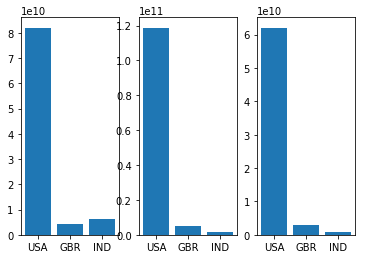

In [188]:
#A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart

plt.subplot(131)
plt.bar(main_sector_by_country.country,main_sector_by_country.raised_amount_usd)
plt.subplot(132)
plt.bar(second_main_sector_by_country.country,second_main_sector_by_country.raised_amount_usd)
plt.subplot(133)
plt.bar(third_main_sector_by_country.country,third_main_sector_by_country.raised_amount_usd)